# TENSORBOARD로 모델, 데이터, 학습 시각화하기

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))]
    )

trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)

testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
    shuffle=True, num_workers=0)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
    shuffle=False, num_workers=0)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 1. TensorBoard 설정

In [7]:
writer = SummaryWriter('runs/fashion_mnist_experiment_1')


## 2. TensorBoard에 기록하기

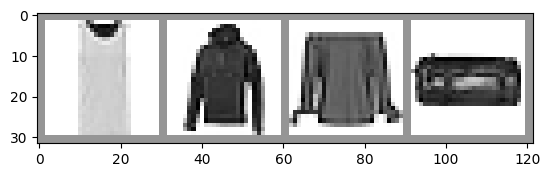

In [8]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)

matplotlib_imshow(img_grid, one_channel=True)

writer.add_image('four_fashion_mnist_images', img_grid)

## 3. TensorBoard를 사용하여 모델 살펴보기(inspect)

In [9]:
writer.add_graph(net, images)
writer.close()

## 4. TensorBoard에 《Projector》 추가하기

In [10]:
def select_n_random(data, labels, n=100):
    '''
    데이터셋에서 n개의 임의의 데이터포인트(datapoint)와 그에 해당하는 라벨을 선택합니다
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

images, labels = select_n_random(trainset.data, trainset.targets)

class_labels = [classes[lab] for lab in labels]

features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

## 5. TensorBoard로 모델 학습 추적하기

In [11]:
def images_to_probs(net, images):
    output = net(images)
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_preds(net, images, labels):
    preds, probs = images_to_probs(net, images)
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [12]:
running_loss = 0.0
for epoch in range(1):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:

            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


## 6. TensorBoard로 학습된 모델 평가하기

In [14]:
class_probs = []
class_label = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]

        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label)